In [16]:
%load_ext autoreload
%autoreload 2
import importlib

from pysentimiento.hate import load_datasets as load_hate
from pysentimiento.tass import load_datasets as load_sentiment
from pysentimiento.emotion import load_datasets as load_emotion
from pysentimiento.irony import load_datasets as load_irony
from transformers import AutoTokenizer

tasks = {
    "hate": load_hate,
    "sentiment": load_sentiment,
    "emotion": load_emotion,
    "irony": load_irony,
}

tokenizers = {
    "beto_uncased" : AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased"),
    "beto_cased" : AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-cased"),
    "roberta" : AutoTokenizer.from_pretrained("BSC-TeMU/roberta-base-bne"),
    "bertin" : AutoTokenizer.from_pretrained("bertin-project/bertin-roberta-base-spanish"),
    "robertuito_cased" : AutoTokenizer.from_pretrained("pysentimiento/robertuito-base-cased"),
    "robertuito_uncased" : AutoTokenizer.from_pretrained("pysentimiento/robertuito-base-uncased"),
    "robertuito_deacc" : AutoTokenizer.from_pretrained("pysentimiento/robertuito-base-deacc"),
}


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import pandas as pd

df = pd.DataFrame()
for task, load_datasets in tasks.items():
    print(f"Task: {task}")
    splits = load_datasets(lang="es")
    dataset = pd.concat([x.to_pandas() for x in splits])
    dataset["task"] = task.upper()
    df = pd.concat([df, dataset.loc[:, ["text", "task"]]])

INFO:pysentimiento:Train path = /content/drive/MyDrive/projects/pysentimiento/data/hate/hateval2019_es_train.csv
INFO:pysentimiento:Dev path = /content/drive/MyDrive/projects/pysentimiento/data/hate/hateval2019_es_dev.csv
INFO:pysentimiento:Test path = /content/drive/MyDrive/projects/pysentimiento/data/hate/hateval2019_es_test.csv


Task: hate
Task: sentiment
4802 2443 7264
Task: emotion
Task: irony


In [20]:
# Les resto 2 por los tokens iniciales y finales

args = {
    "truncation": True,
    "max_length": 128,
}

for tok_name, tokenizer in tokenizers.items():
    df[tok_name] = [sum(x) - 2 for x in tokenizer(list(df["text"].values), **args)["attention_mask"]]

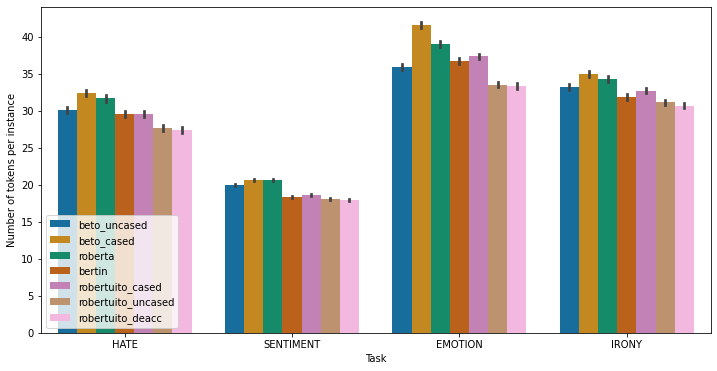

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

melted_df = df.melt(id_vars=["task"],
    value_vars=tokenizers.keys(), var_name="tokenizer", value_name="length")

plt.figure(figsize=(12, 6))

sns.barplot(
    x="task", y="length", hue="tokenizer", data=melted_df, ci=95, palette="colorblind")

plt.xlabel("Task")
plt.ylabel("Number of tokens per instance")
plt.legend(loc="lower left")
plt.savefig("spanish_token_lengths.pdf", bbox_inches="tight")

In [38]:
mean_df = melted_df.groupby(["task", "tokenizer"]).mean().sort_values(by="length").round(2)
std_df = melted_df.groupby(["task", "tokenizer"]).std().sort_values(by="length").round(1)

std_df

length
task      tokenizer                 
SENTIMENT robertuito_deacc       7.6
          robertuito_uncased     7.6
          robertuito_cased       7.9
          bertin                 8.3
          beto_uncased           8.4
          roberta                8.4
          beto_cased             8.8
EMOTION   robertuito_deacc      16.3
          robertuito_uncased    16.4
HATE      robertuito_deacc      16.6
          robertuito_uncased    16.7
IRONY     robertuito_deacc      17.2
          robertuito_uncased    17.4
HATE      beto_uncased          17.5
EMOTION   robertuito_cased      17.7
          beto_uncased          17.7
HATE      robertuito_cased      17.9
          roberta               18.1
          bertin                18.1
IRONY     beto_uncased          18.1
          robertuito_cased      18.2
HATE      beto_cased            19.1
EMOTION   bertin                19.1
IRONY     bertin                19.2
          roberta               19.3
EMOTION   roberta               19.4
IRONY     beto_cased            19.5
EMOTION   beto_cased            19.7

In [54]:
pepe_df = mean_df.astype(str) + " ± " + std_df.astype(str)

print(pepe_df.unstack(0).to_latex())

\begin{tabular}{lllll}
\toprule
{} & \multicolumn{4}{l}{length} \\
task &       EMOTION &          HATE &         IRONY &    SENTIMENT \\
tokenizer          &               &               &               &              \\
\midrule
bertin             &  36.68 ± 19.1 &  29.56 ± 18.1 &  31.87 ± 19.2 &  18.33 ± 8.3 \\
beto\_cased         &  41.55 ± 19.7 &   32.4 ± 19.1 &  34.92 ± 19.5 &  20.66 ± 8.8 \\
beto\_uncased       &  35.94 ± 17.7 &  30.06 ± 17.5 &  33.14 ± 18.1 &  19.95 ± 8.4 \\
roberta            &  39.02 ± 19.4 &  31.67 ± 18.1 &  34.21 ± 19.3 &  20.68 ± 8.4 \\
robertuito\_cased   &  37.33 ± 17.7 &  29.51 ± 17.9 &  32.71 ± 18.2 &  18.64 ± 7.9 \\
robertuito\_deacc   &  33.31 ± 16.3 &  27.39 ± 16.6 &   30.7 ± 17.2 &  17.92 ± 7.6 \\
robertuito\_uncased &   33.5 ± 16.4 &   27.7 ± 16.7 &  31.12 ± 17.4 &  18.08 ± 7.6 \\
\bottomrule
\end{tabular}



In [46]:
pepe_df = mean_df.astype(str) + " ± " + std_df.astype(str)

pepe_df.unstack(0).to_latex()

'\\begin{tabular}{lllll}\n\\toprule\n{} & \\multicolumn{4}{l}{length} \\\\\ntask &       EMOTION &          HATE &         IRONY &    SENTIMENT \\\\\ntokenizer          &               &               &               &              \\\\\n\\midrule\nbertin             &  36.68 ± 19.1 &  29.56 ± 18.1 &  31.87 ± 19.2 &  18.33 ± 8.3 \\\\\nbeto\\_cased         &  41.55 ± 19.7 &   32.4 ± 19.1 &  34.92 ± 19.5 &  20.66 ± 8.8 \\\\\nbeto\\_uncased       &  35.94 ± 17.7 &  30.06 ± 17.5 &  33.14 ± 18.1 &  19.95 ± 8.4 \\\\\nroberta            &  39.02 ± 19.4 &  31.67 ± 18.1 &  34.21 ± 19.3 &  20.68 ± 8.4 \\\\\nrobertuito\\_cased   &  37.33 ± 17.7 &  29.51 ± 17.9 &  32.71 ± 18.2 &  18.64 ± 7.9 \\\\\nrobertuito\\_deacc   &  33.31 ± 16.3 &  27.39 ± 16.6 &   30.7 ± 17.2 &  17.92 ± 7.6 \\\\\nrobertuito\\_uncased &   33.5 ± 16.4 &   27.7 ± 16.7 &  31.12 ± 17.4 &  18.08 ± 7.6 \\\\\n\\bottomrule\n\\end{tabular}\n'